In [1]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [2]:

%matplotlib inline
from google.colab import files
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix 
print(tf.__version__)

2.9.2


In [3]:

imagepaths = []

for root, dirs, files in os.walk("mydrive/My Drive/DCGAN/", topdown=False): 
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"): 
      imagepaths.append(path)

print(len(imagepaths)) 

1005


In [4]:
X = [] 
y = [] 


for path in imagepaths:
  img = cv2.imread(path) 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  img = cv2.resize(img, (28, 28))
  X.append(img)
  

  category = path.split("/")[3]
  label = int(category.split(" ")[1]) 
  y.append(label)


X = np.array(X, dtype="uint8")
#X = X.reshape(len(imagepaths), 232, 424, 3) # 
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging

Images loaded:  1005
Labels loaded:  1005
4 mydrive/My Drive/DCGAN/Class 4/11.png


In [5]:
ts = 0.2
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=43)

In [6]:
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0
x_train.shape, x_test.shape

((804, 28, 28), (201, 28, 28))

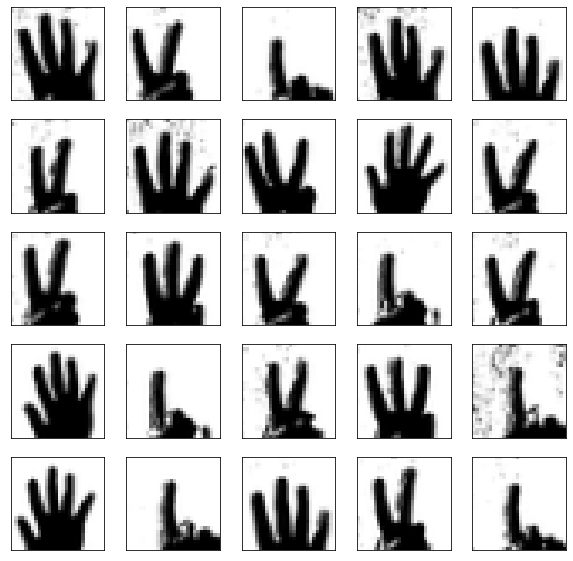

In [ ]:
# We plot first 25 images of training dataset
plt.figure(figsize =(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap = plt.cm.binary)
plt.show()

In [7]:

batch_size = 32

def create_batch(x_train):
  dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
 
  dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)
  return dataset

In [8]:


num_features = 100
 
generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape =[num_features]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(
        64, (5, 5), (2, 2), padding ="same", activation ="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(
        1, (5, 5), (2, 2), padding ="same", activation ="tanh"),
])
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       204864    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                        

In [9]:

discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5, 5), (2, 2), padding ="same", input_shape =[28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5, 5), (2, 2), padding ="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation ='sigmoid')
])
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [10]:
import keras.backend as K
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [11]:

from keras.optimizers import RMSprop

optimizer = RMSprop(learning_rate=0.00005)
discriminator.compile(loss =wasserstein_loss, optimizer =optimizer, metrics=['accuracy'])
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])

gan.compile(loss =wasserstein_loss, optimizer =optimizer ,metrics=['accuracy'])

In [13]:
def noisy_labels(p_flip, y):
 # determine the number of labels to flip
  n_select = int(p_flip * len(y))
  flip_ix = choice([i for i in range(len(y))], size=n_select)
  for i in flip_ix:
    y[i][0]= 0 - y[i][0]
    if(y[i][0]<0):
      y[i][0]=-1
		
  return y

In [14]:
from numpy.random import random
from numpy.random import choice

seed = tf.random.normal(shape =[batch_size, 100])
D_loss=[]
D_acc=[]
G_acc=[]
G_loss=[]
def train_dcgan(gan, dataset, batch_size, num_features, epochs = 50):
	generator, discriminator = gan.layers
	for epoch in range(epochs):
		print()
		print("Epoch {}/{}".format(epoch + 1, epochs))

		for X_batch in dataset:
			# نویز  * 100
			# دادن نویز به شبکه مولد
			noise = tf.random.normal(shape =[batch_size, num_features])
			generated_images = generator(noise)

			# یک دسته از تصاویر واقعی و ساختگی می سازیم
			# از آن ها برای آموزش شبکه تفکیک کننده استفاده می کنیم
			X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0)
			y_fake=([[1.]] * batch_size)
			y_fake_smooth= [[x[0] + -0.1 +(random() * 0.2)] for x in y_fake]
			y_fake_smooth_noise=noisy_labels(0.05,y_fake_smooth)

			y_real=([[-1.]] * batch_size)
			y_real_no_smooth=[[x[0]] for x in y_real]
			y_real_noise=noisy_labels(0.05,y_real_no_smooth)
			y1 = tf.constant(y_real_noise + y_fake_smooth_noise)

			discriminator.trainable = True
			#d_loss_real = discriminator.train_on_batch(x=X_batch, y=-np.ones((batch_size, 1)))
			d_loss,d_acc=discriminator.train_on_batch(X_fake_and_real, y1)
			D_loss.append(d_loss)
			D_acc.append(d_acc)
			# تصویر ساخته شده توسط شبکه مولد را با لیبل 1 به شبکه تفکیک کننده می دهیم
			noise = tf.random.normal(shape =[batch_size, num_features])
			y2 = tf.constant([[1.]] * batch_size)
			discriminator.trainable = False
			g_loss,g_acc=gan.train_on_batch(noise, y2)
			G_loss.append(g_loss)
			G_acc.append(g_acc)
	 		

		print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (epoch + 1, epochs, D_loss[-1], G_loss[-1]), 100*' ')
		if epoch % 5 == 0:
			samples = 10
			x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, num_features)))

			for k in range(samples):
				plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
				plt.imshow(x_fake[k, :, :, 0] * 127.5 + 127.5, cmap ='binary')


			plt.tight_layout()
			plt.show()

	#generate_and_save_images(generator, epochs, seed)



Epoch 1/50
epoch = 1/50, d_loss=-0.166, g_loss=0.388                                                                                                     
1/1 [==============================] - 0s 135ms/step


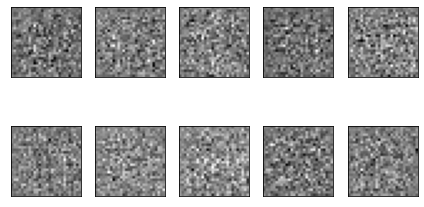


Epoch 2/50
epoch = 2/50, d_loss=-0.201, g_loss=0.353                                                                                                     

Epoch 3/50
epoch = 3/50, d_loss=-0.220, g_loss=0.392                                                                                                     

Epoch 4/50
epoch = 4/50, d_loss=-0.228, g_loss=0.511                                                                                                     

Epoch 5/50
epoch = 5/50, d_loss=-0.249, g_loss=0.621                                                                                                     

Epoch 6/50
epoch = 6/50, d_loss=-0.307, g_loss=0.695                                                                                                     
1/1 [==============================] - 0s 21ms/step


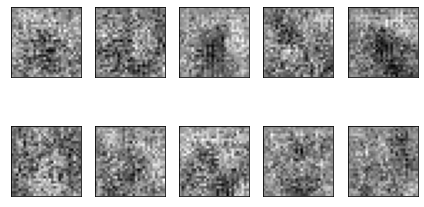


Epoch 7/50
epoch = 7/50, d_loss=-0.309, g_loss=0.704                                                                                                     

Epoch 8/50
epoch = 8/50, d_loss=-0.291, g_loss=0.633                                                                                                     

Epoch 9/50
epoch = 9/50, d_loss=-0.273, g_loss=0.620                                                                                                     

Epoch 10/50
epoch = 10/50, d_loss=-0.272, g_loss=0.572                                                                                                     

Epoch 11/50
epoch = 11/50, d_loss=-0.239, g_loss=0.605                                                                                                     
1/1 [==============================] - 0s 19ms/step


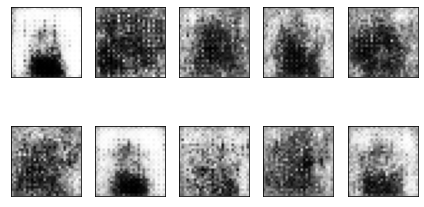


Epoch 12/50
epoch = 12/50, d_loss=-0.293, g_loss=0.543                                                                                                     

Epoch 13/50
epoch = 13/50, d_loss=-0.269, g_loss=0.619                                                                                                     

Epoch 14/50
epoch = 14/50, d_loss=-0.199, g_loss=0.642                                                                                                     

Epoch 15/50
epoch = 15/50, d_loss=-0.244, g_loss=0.506                                                                                                     

Epoch 16/50
epoch = 16/50, d_loss=-0.220, g_loss=0.449                                                                                                     
1/1 [==============================] - 0s 14ms/step


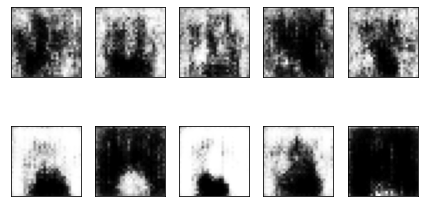


Epoch 17/50
epoch = 17/50, d_loss=-0.220, g_loss=0.479                                                                                                     

Epoch 18/50
epoch = 18/50, d_loss=-0.216, g_loss=0.547                                                                                                     

Epoch 19/50
epoch = 19/50, d_loss=-0.181, g_loss=0.548                                                                                                     

Epoch 20/50
epoch = 20/50, d_loss=-0.128, g_loss=0.444                                                                                                     

Epoch 21/50
epoch = 21/50, d_loss=-0.183, g_loss=0.467                                                                                                     
1/1 [==============================] - 0s 14ms/step


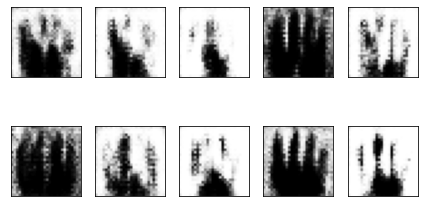


Epoch 22/50
epoch = 22/50, d_loss=-0.199, g_loss=0.414                                                                                                     

Epoch 23/50
epoch = 23/50, d_loss=-0.137, g_loss=0.414                                                                                                     

Epoch 24/50
epoch = 24/50, d_loss=-0.119, g_loss=0.402                                                                                                     

Epoch 25/50
epoch = 25/50, d_loss=-0.123, g_loss=0.358                                                                                                     

Epoch 26/50
epoch = 26/50, d_loss=-0.115, g_loss=0.392                                                                                                     
1/1 [==============================] - 0s 14ms/step


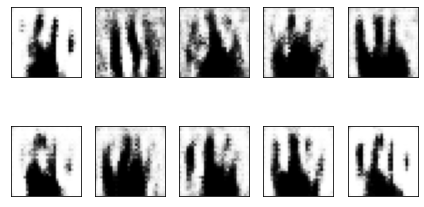


Epoch 27/50
epoch = 27/50, d_loss=-0.091, g_loss=0.286                                                                                                     

Epoch 28/50
epoch = 28/50, d_loss=-0.058, g_loss=0.256                                                                                                     

Epoch 29/50
epoch = 29/50, d_loss=-0.014, g_loss=0.502                                                                                                     

Epoch 30/50
epoch = 30/50, d_loss=-0.020, g_loss=0.805                                                                                                     

Epoch 31/50
epoch = 31/50, d_loss=-0.046, g_loss=0.816                                                                                                     
1/1 [==============================] - 0s 17ms/step


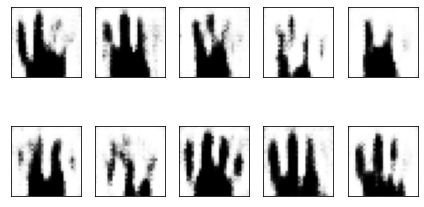


Epoch 32/50
epoch = 32/50, d_loss=0.006, g_loss=0.936                                                                                                     

Epoch 33/50
epoch = 33/50, d_loss=-0.054, g_loss=0.615                                                                                                     

Epoch 34/50
epoch = 34/50, d_loss=-0.029, g_loss=0.592                                                                                                     

Epoch 35/50
epoch = 35/50, d_loss=-0.050, g_loss=0.672                                                                                                     

Epoch 36/50
epoch = 36/50, d_loss=0.006, g_loss=0.624                                                                                                     
1/1 [==============================] - 0s 13ms/step


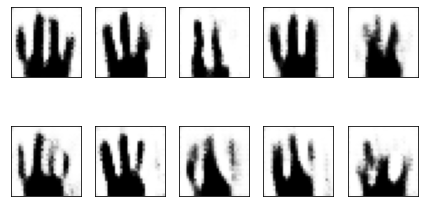


Epoch 37/50
epoch = 37/50, d_loss=-0.040, g_loss=0.561                                                                                                     

Epoch 38/50
epoch = 38/50, d_loss=-0.017, g_loss=0.739                                                                                                     

Epoch 39/50
epoch = 39/50, d_loss=0.001, g_loss=0.634                                                                                                     

Epoch 40/50
epoch = 40/50, d_loss=-0.045, g_loss=0.650                                                                                                     

Epoch 41/50
epoch = 41/50, d_loss=0.006, g_loss=0.668                                                                                                     
1/1 [==============================] - 0s 15ms/step


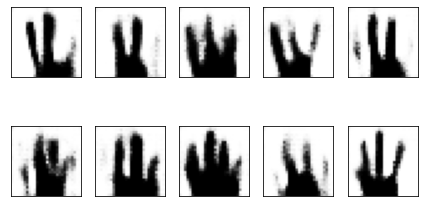


Epoch 42/50
epoch = 42/50, d_loss=0.002, g_loss=0.680                                                                                                     

Epoch 43/50
epoch = 43/50, d_loss=-0.032, g_loss=0.463                                                                                                     

Epoch 44/50
epoch = 44/50, d_loss=-0.067, g_loss=0.612                                                                                                     

Epoch 45/50
epoch = 45/50, d_loss=-0.039, g_loss=0.526                                                                                                     

Epoch 46/50
epoch = 46/50, d_loss=-0.037, g_loss=0.603                                                                                                     
1/1 [==============================] - 0s 20ms/step


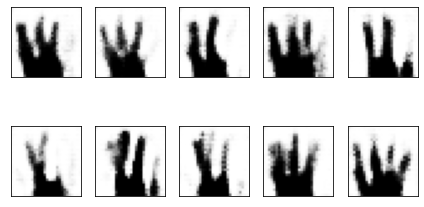


Epoch 47/50
epoch = 47/50, d_loss=-0.037, g_loss=0.611                                                                                                     

Epoch 48/50
epoch = 48/50, d_loss=-0.044, g_loss=0.695                                                                                                     

Epoch 49/50
epoch = 49/50, d_loss=-0.063, g_loss=0.590                                                                                                     

Epoch 50/50
epoch = 50/50, d_loss=-0.036, g_loss=0.547                                                                                                     


In [15]:

# reshape to add a color map
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.
# create batches
dataset = create_batch(x_train_dcgan)
# callthe training function with 10 epochs and record time %% time
train_dcgan(gan, dataset, batch_size, num_features, epochs = 50)

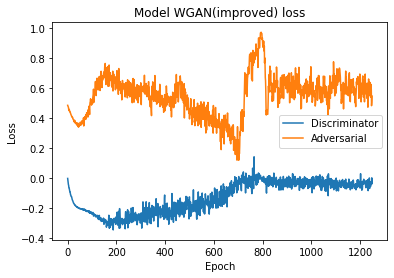

In [16]:
plt.plot(D_loss)
plt.plot(G_loss)
plt.title('Model WGAN(improved) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

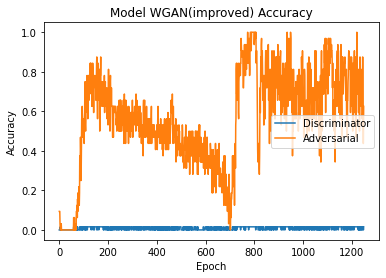

In [17]:
plt.plot(D_acc)
plt.plot(G_acc)
plt.title('Model WGAN(improved) Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()